In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import gc, math, os, warnings
warnings.simplefilter("ignore")
from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
import lightgbm as lgb

In [2]:
FOLDER = "../features/"
df_train = pd.read_pickle(FOLDER + "train_features.pkl")
df_test = pd.read_pickle(FOLDER + "test_features.pkl")

print("train/test shape is:", df_train.shape, df_test.shape)

train/test shape is: (19228395, 18) (41697600, 17)


In [3]:
df_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,apparent_temperature,log_meter_reading,DT_hour,DT_day_week,timestamp_og
16418015,1262,0,0.0,110.51,14,6,11.085938,NaN,NaN,3.934783,1.25,-3.282609,0.0,0.350981,4.714114,0,4,2016-01-01
16418016,1262,1,0.0,116.00,14,6,11.085938,NaN,NaN,3.934783,1.25,-3.282609,0.0,0.350981,4.762174,0,4,2016-01-01
16418017,1262,3,0.0,855.10,14,6,11.085938,NaN,NaN,3.934783,1.25,-3.282609,0.0,0.350981,6.752387,0,4,2016-01-01
2639831,226,0,0.0,29.45,2,6,11.210938,1930.0,NaN,15.600000,6.00,-5.600000,0.0,11.439780,3.416086,0,4,2016-01-01
3350958,262,0,0.0,16.84,2,1,9.945312,1999.0,NaN,15.600000,6.00,-5.600000,0.0,11.439780,2.881443,0,4,2016-01-01


In [4]:
# set category feature
categorical_features = [
    "building_id",  #
    "primary_use",
    "DT_day_week",
    "DT_hour",
]
for col in categorical_features:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

In [5]:
# drop useless features
drop_features = [
    "timestamp",  #
    "timestamp_og",
    "site_id",
    'meter',
    "meter_reading",
    "log_meter_reading",
    "year_built",
    "floor_count",
]
all_features = [col for col in df_train.columns if col not in drop_features]

In [6]:
print("train/test shape is:", df_train.shape, df_test.shape)
print("features used # is", len(all_features))
df_train[all_features].head()

train/test shape is: (19228395, 18) (41697600, 17)
features used # is 10


,building_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,apparent_temperature,DT_hour,DT_day_week
16418015,1262,6,11.085938,3.934783,1.25,-3.282609,0.0,0.350981,0,4
16418016,1262,6,11.085938,3.934783,1.25,-3.282609,0.0,0.350981,0,4
16418017,1262,6,11.085938,3.934783,1.25,-3.282609,0.0,0.350981,0,4
2639831,226,6,11.210938,15.600000,6.00,-5.600000,0.0,11.439780,0,4
3350958,262,1,9.945312,15.600000,6.00,-5.600000,0.0,11.439780,0,4


In [7]:
cv = 2
models = {}
site_model = {}
cv_scores = {"site_id": [], "meter_id":[], "cv_score": []}
USE_GRID_SEARCH = True

for site_id in tqdm_notebook(range(16), desc="site_id"):
    
    models[site_id] = []
    site_model = {}
    for meter_id in range(4):
        
        ### train a single model for each site/meter
        X_train_site = df_train[(df_train.site_id==site_id) & (df_train.meter==meter_id)].reset_index(drop=True)
        y_train_site = X_train_site.log_meter_reading
        y_pred_train_site = np.zeros(X_train_site.shape[0])
        
        if(len(X_train_site)==0):
            print("Site Id:", site_id, "meter Id:", meter_id, "has no training data!")
            continue
        
        print("==> Training model for site_id:", site_id, "meter:", meter_id, "...")
        
        kf = KFold(n_splits=cv)
        skf = StratifiedKFold(n_splits=cv, shuffle=False, random_state=42)
        
        site_model[meter_id] = []
        score = 0

        #################### grid search #############################################
        if(USE_GRID_SEARCH):
            estimator = lgb.LGBMRegressor()
            param_grid = {
                'metric': ['rmse'],
#                 'num_leaves': [16, 32],
                'max_depth': [4, 5, 6],
                'learning_rate': [0.05],
                'n_estimators': [2000],
                'subsample': [0.85], 
                'lambda_l2':[0.1],
                'seed': [10086],
                'n_jobs':[-1]
            }
            gbm = GridSearchCV(estimator, param_grid, cv=skf.split(X_train_site, X_train_site.building_id))
            gbm.fit(X_train_site[all_features], y_train_site)
            print('Best parameters found by grid search are:', gbm.best_params_)
        else:
            param = {
                'metric': 'rmse',
                'num_leaves': 16,
                'learning_rate': 0.01,
                'n_estimators': 5000,
                'subsample': 0.85, 
                "lambda_l2":0.1,
                "max_depth":5,
                'seed': 19930826,
                'n_jobs':-1
            }
            
        #skf.split(X_train_site, X_train_site.building_id)
        #kf.split(X_train_site)
        for fold, (train_index, valid_index) in enumerate(skf.split(X_train_site, X_train_site.building_id)):
            X_train, X_valid = X_train_site.loc[train_index, all_features], X_train_site.loc[valid_index, all_features]
            y_train, y_valid = y_train_site.iloc[train_index], y_train_site.iloc[valid_index]
            
#             print(X_train.building_id.nunique(), " == ", X_valid.building_id.nunique())
            print("train/valid size", X_train.shape, X_valid.shape)
            
            if(USE_GRID_SEARCH):
                model_lgb = lgb.LGBMRegressor(**gbm.best_params_)
            else:
                model_lgb = lgb.LGBMRegressor(**param)
            
            model_lgb.fit(X_train, y_train,
#                 eval_set=[(X_train_site[all_features], y_train_site)],
                eval_set=[(X_valid, y_valid)],
                categorical_feature=categorical_features,
                early_stopping_rounds=300,
                verbose=1000)
        
            site_model[meter_id].append(model_lgb)

            y_pred_valid = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration_)
            y_pred_train_site[valid_index] = y_pred_valid

            rmse = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
            print("Site Id:", site_id, "meter Id:", meter_id, ", Fold:", fold+1, ", RMSE:", rmse)
            score += rmse / cv

            gc.collect()
        
        cv_scores["site_id"].append(site_id)
        cv_scores["meter_id"].append(meter_id)
        cv_scores["cv_score"].append(score)
        
        print("\nSite Id:", site_id, "meter Id:", meter_id, ", CV RMSE:", np.sqrt(mean_squared_error(y_train_site, y_pred_train_site)), "\n")
    models[site_id].append(site_model)

==> Training model for site_id: 0 meter: 0 ...
Best parameters found by grid search are: {'lambda_l2': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'metric': 'rmse', 'n_estimators': 2000, 'n_jobs': -1, 'seed': 10086, 'subsample': 0.85}
train/valid size (278987, 10) (279013, 10)
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[567]	valid_0's rmse: 0.297413
Site Id: 0 meter Id: 0 , Fold: 1 , RMSE: 0.297412859016615
train/valid size (279013, 10) (278987, 10)
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[364]	valid_0's rmse: 0.378812
Site Id: 0 meter Id: 0 , Fold: 2 , RMSE: 0.3788115653539311

Site Id: 0 meter Id: 0 , CV RMSE: 0.3405510578384455 

==> Training model for site_id: 0 meter: 1 ...
Best parameters found by grid search are: {'lambda_l2': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'metric': 'rmse', 'n_estimators': 2000, 'n_jobs': -1, 'seed': 10086, 'subsample': 0.85}
train/valid s

Best parameters found by grid search are: {'lambda_l2': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'metric': 'rmse', 'n_estimators': 2000, 'n_jobs': -1, 'seed': 10086, 'subsample': 0.85}
train/valid size (157687, 10) (157707, 10)
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[162]	valid_0's rmse: 0.309837
Site Id: 6 meter Id: 0 , Fold: 1 , RMSE: 0.309837499720692
train/valid size (157707, 10) (157687, 10)
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's rmse: 0.292682
Early stopping, best iteration is:
[1122]	valid_0's rmse: 0.292558
Site Id: 6 meter Id: 0 , Fold: 2 , RMSE: 0.29255812261907926

Site Id: 6 meter Id: 0 , CV RMSE: 0.30132224561770693 

==> Training model for site_id: 6 meter: 1 ...
Best parameters found by grid search are: {'lambda_l2': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'metric': 'rmse', 'n_estimators': 2000, 'n_jobs': -1, 'seed': 10086, 'subsample': 0.85}
train/valid size (62215, 

Early stopping, best iteration is:
[116]	valid_0's rmse: 1.24779
Site Id: 9 meter Id: 2 , Fold: 2 , RMSE: 1.247785116054871

Site Id: 9 meter Id: 2 , CV RMSE: 1.2239287837869965 

Site Id: 9 meter Id: 3 has no training data!
==> Training model for site_id: 10 meter: 0 ...
Best parameters found by grid search are: {'lambda_l2': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'metric': 'rmse', 'n_estimators': 2000, 'n_jobs': -1, 'seed': 10086, 'subsample': 0.85}
train/valid size (118031, 10) (118051, 10)
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[341]	valid_0's rmse: 0.402578
Site Id: 10 meter Id: 0 , Fold: 1 , RMSE: 0.40257781651068225
train/valid size (118051, 10) (118031, 10)
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[372]	valid_0's rmse: 0.435005
Site Id: 10 meter Id: 0 , Fold: 2 , RMSE: 0.4350053498826663

Site Id: 10 meter Id: 0 , CV RMSE: 0.41910395596650335 

==> Training mod

train/valid size (425093, 10) (425137, 10)
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[143]	valid_0's rmse: 0.281266
Site Id: 14 meter Id: 0 , Fold: 1 , RMSE: 0.28126636746189315
train/valid size (425137, 10) (425093, 10)
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's rmse: 0.297919
Early stopping, best iteration is:
[715]	valid_0's rmse: 0.29751
Site Id: 14 meter Id: 0 , Fold: 2 , RMSE: 0.2975103806808699

Site Id: 14 meter Id: 0 , CV RMSE: 0.2895019080556468 

==> Training model for site_id: 14 meter: 1 ...
Best parameters found by grid search are: {'lambda_l2': 0.1, 'learning_rate': 0.05, 'max_depth': 4, 'metric': 'rmse', 'n_estimators': 2000, 'n_jobs': -1, 'seed': 10086, 'subsample': 0.85}
train/valid size (341651, 10) (341679, 10)
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[202]	valid_0's rmse: 1.40459
Site Id: 14 meter Id: 1 , Fold: 1 , RMSE:

In [8]:
### compute weight cv score
def weight_cv_score(df_train, cv_score_df):
    
    mini_model_portion = []
    for site_id in tqdm_notebook(range(16), desc="site_id"):
        for meter_id in range(4):
            X_train_site = df_train[(df_train.site_id==site_id) & (df_train.meter==meter_id)].reset_index(drop=True)
            if(len(X_train_site) != 0):
                portion_rate = np.round(X_train_site.shape[0] / df_train.shape[0] * 100, 2)
                print("site_id:", site_id, "meter:",meter_id, "---", X_train_site.building_id.nunique(),"buildings", portion_rate, "% :", cv_score_df[cv_score_df.site_id==site_id][cv_score_df.meter_id==meter_id]['cv_score'].values.round(4))                
                mini_model_portion.append(X_train_site.shape[0] / df_train.shape[0])
        print("--------------------------------------------")
    cv_weight_score = np.array(mini_model_portion) * (np.array(cv_score_df.cv_score) ** 2)
    weighted_score = np.round(cv_weight_score.sum() ** 0.5, 4)
    
    return weighted_score
cv_score_df = pd.DataFrame.from_dict(cv_scores)
print("Overall CV score is:", weight_cv_score(df_train, cv_score_df))

site_id: 0 meter: 0 --- 105 buildings 2.9 % : [0.3381]
site_id: 0 meter: 1 --- 24 buildings 0.84 % : [1.3372]
--------------------------------------------
site_id: 1 meter: 0 --- 51 buildings 2.33 % : [0.6369]
site_id: 1 meter: 3 --- 12 buildings 0.54 % : [1.7755]
--------------------------------------------
site_id: 2 meter: 0 --- 135 buildings 6.11 % : [0.4144]
site_id: 2 meter: 1 --- 99 buildings 4.29 % : [0.895]
site_id: 2 meter: 3 --- 55 buildings 2.04 % : [0.9501]
--------------------------------------------
site_id: 3 meter: 0 --- 274 buildings 12.31 % : [0.4303]
--------------------------------------------
site_id: 4 meter: 0 --- 91 buildings 3.86 % : [0.2152]
--------------------------------------------
site_id: 5 meter: 0 --- 89 buildings 4.02 % : [0.656]
--------------------------------------------
site_id: 6 meter: 0 --- 36 buildings 1.64 % : [0.3012]
site_id: 6 meter: 1 --- 21 buildings 0.65 % : [1.2283]
site_id: 6 meter: 2 --- 23 buildings 0.89 % : [1.483]
---------------

---

In [9]:
# del df_train, X_train_site, y_train_site, X_train, y_train, dtrain, X_valid, y_valid, dvalid, y_pred_train_site, y_pred_valid, rmse, score, cv_scores
# gc.collect()

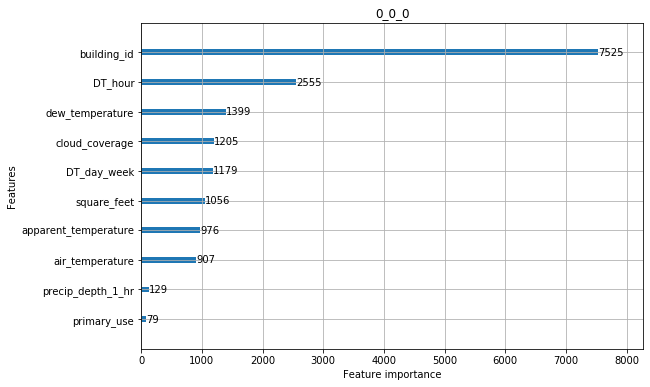

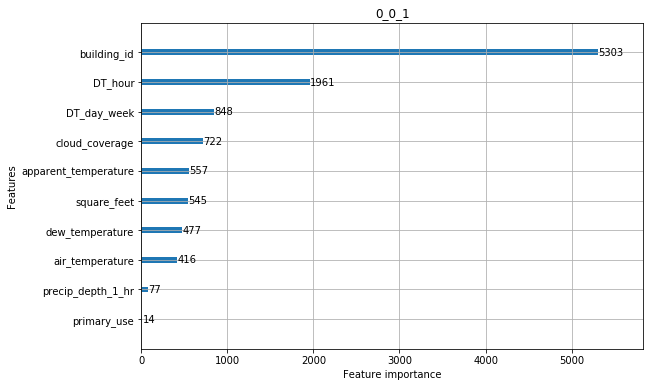

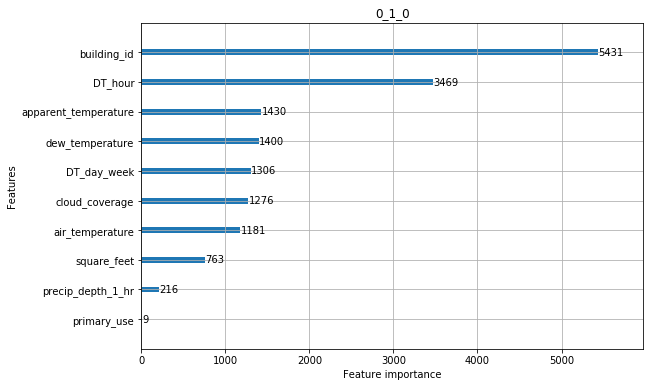

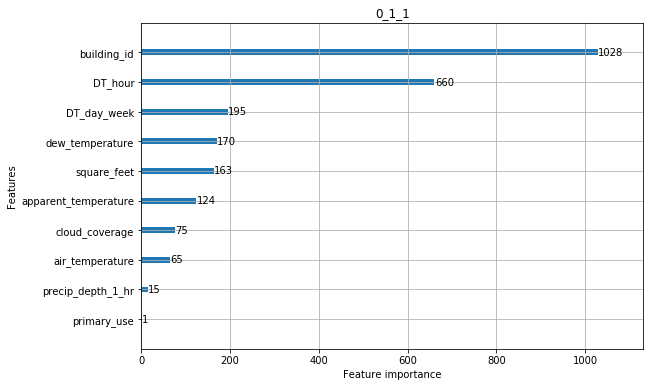

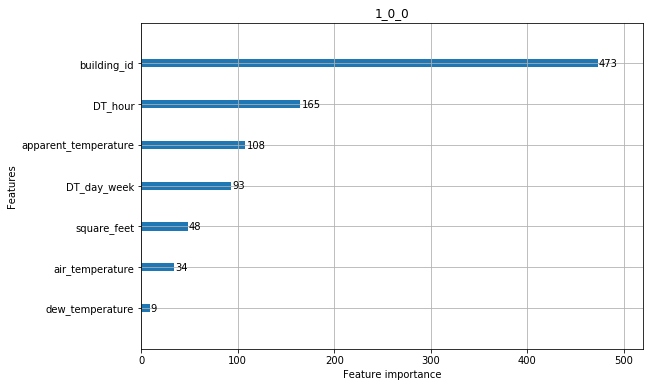

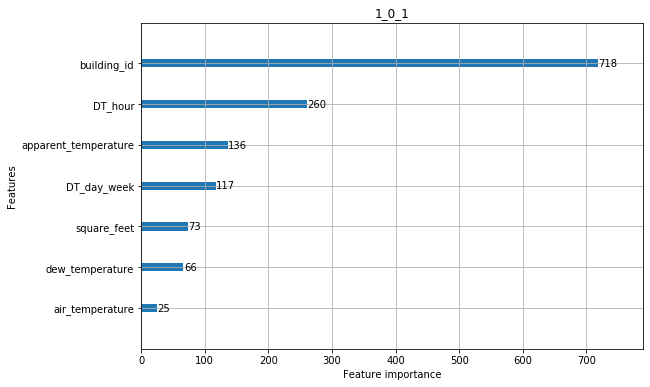

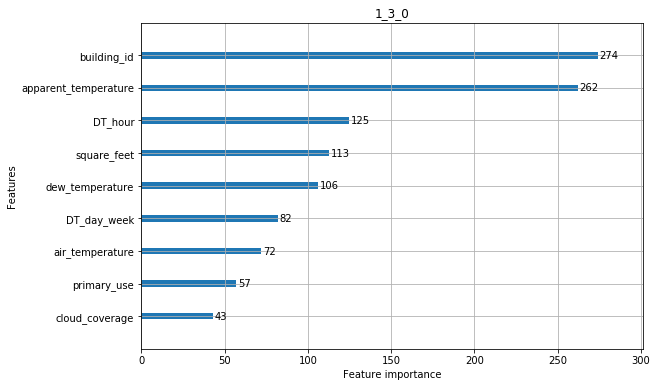

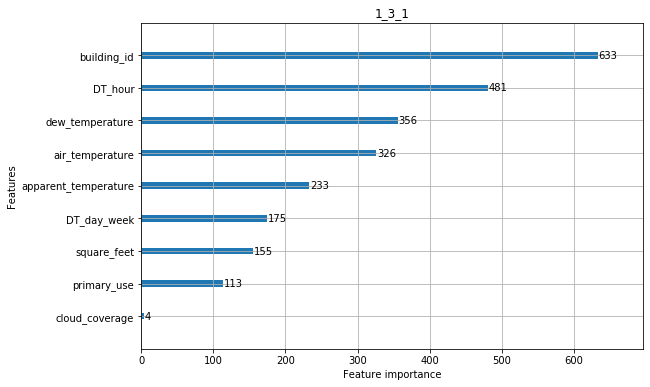

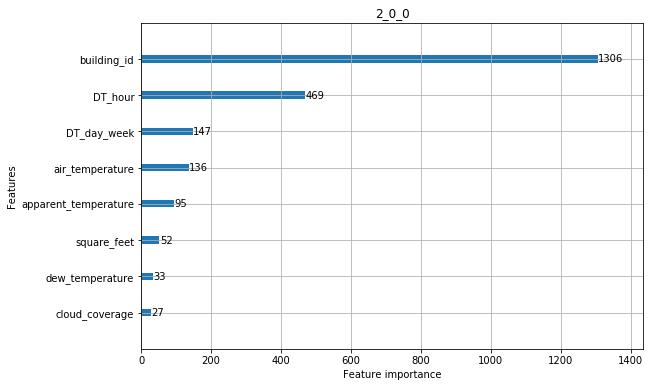

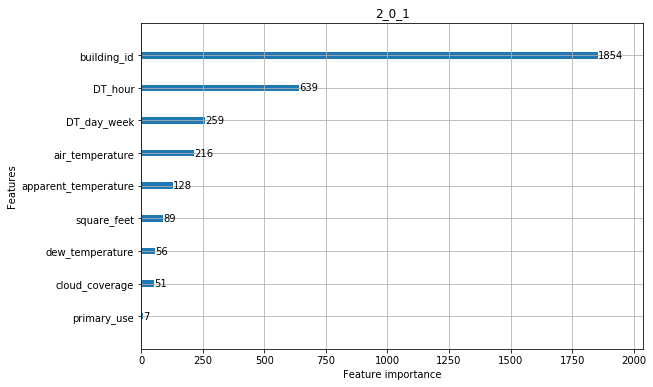

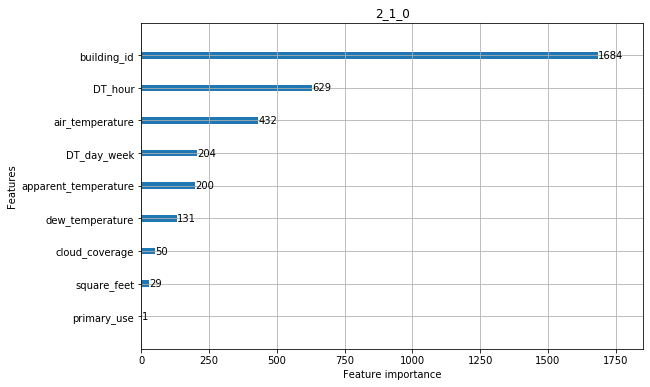

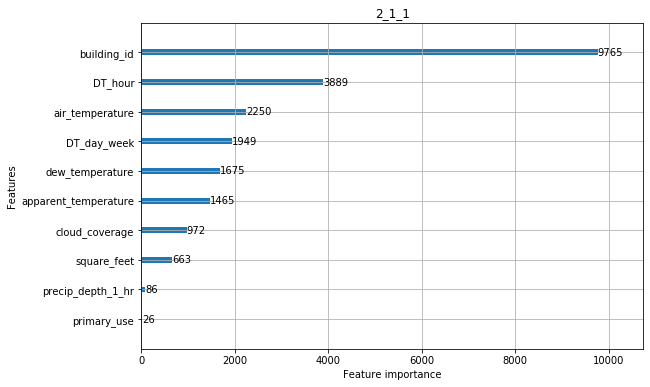

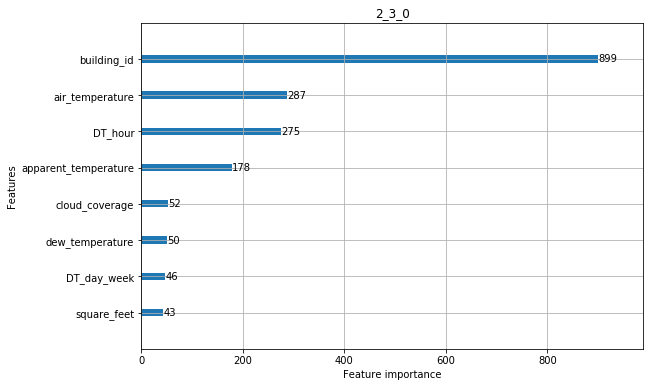

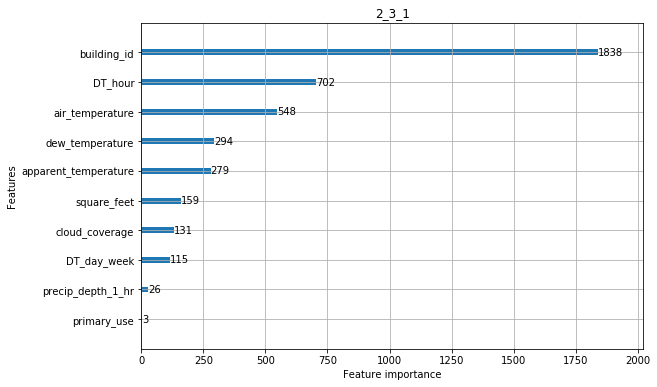

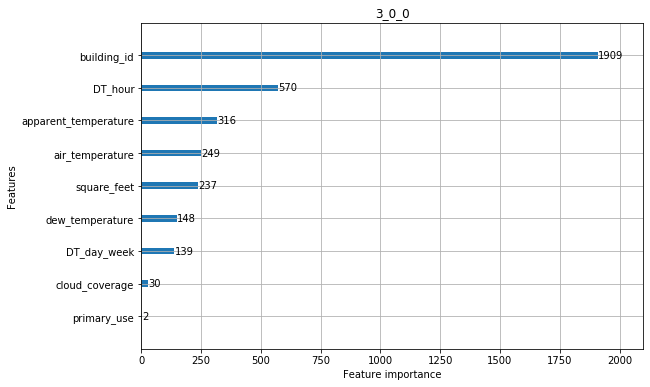

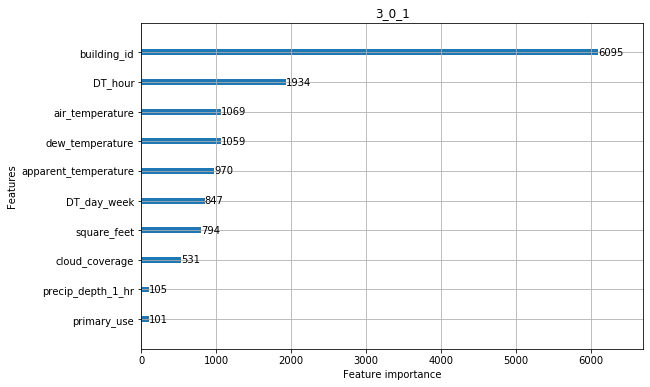

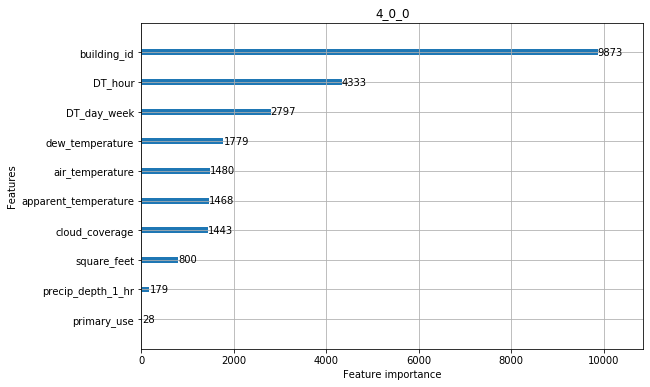

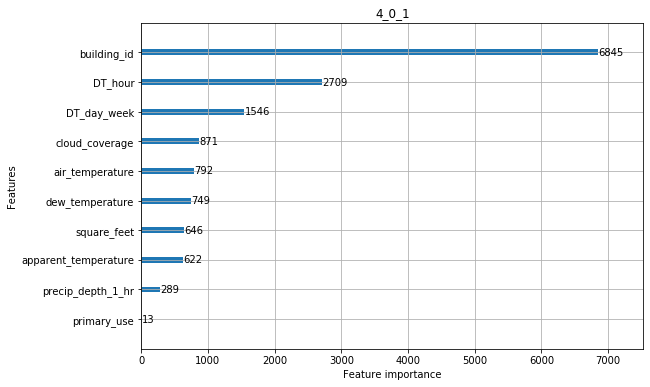

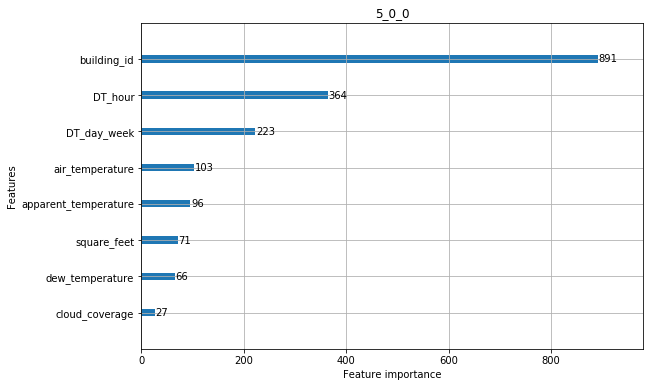

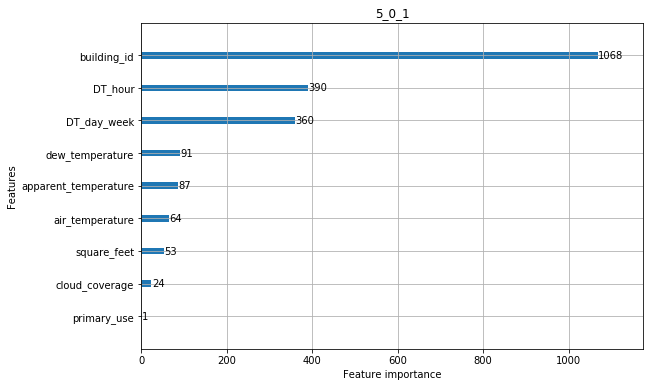

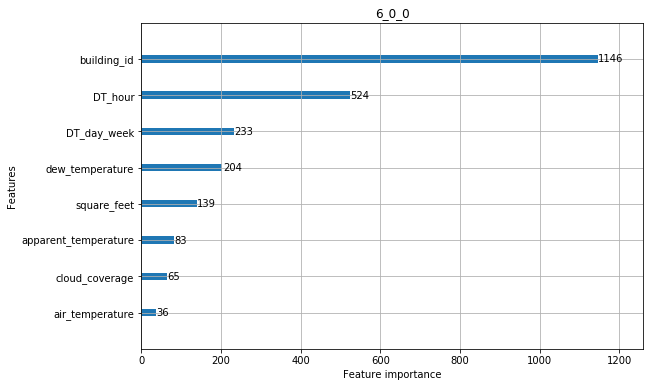

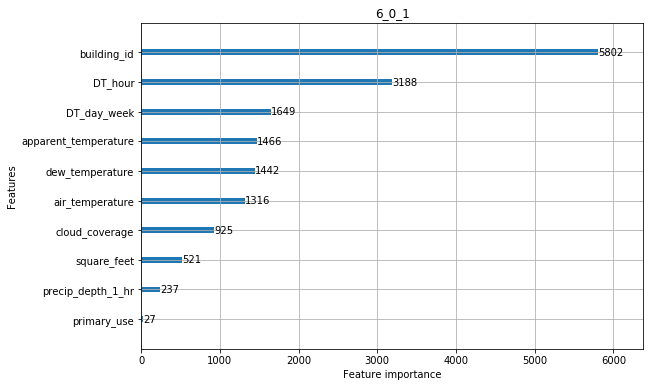

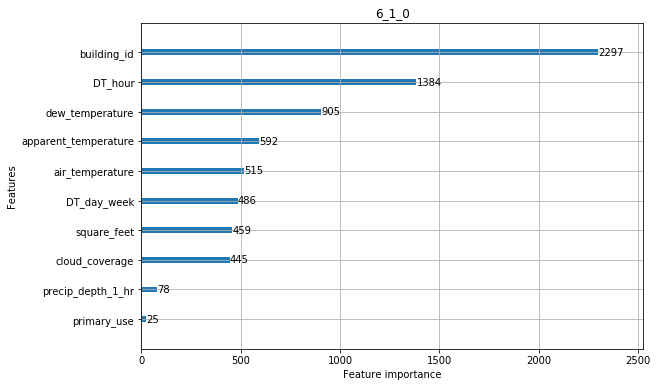

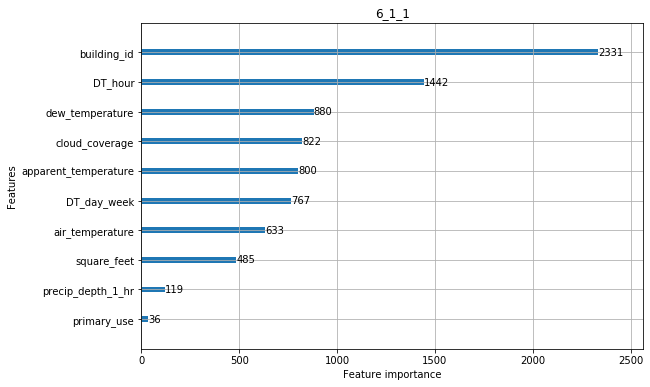

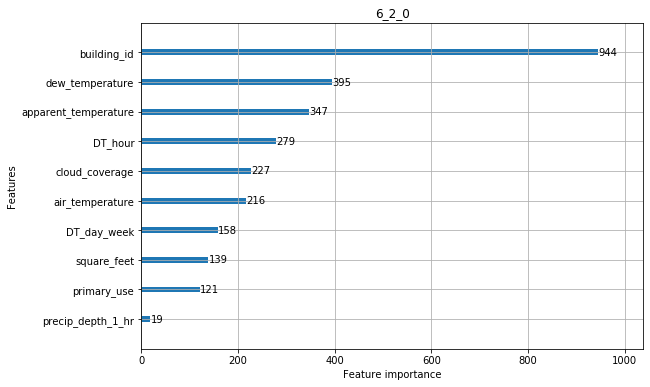

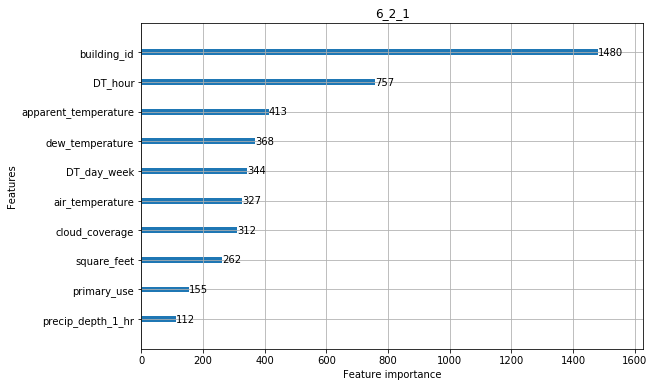

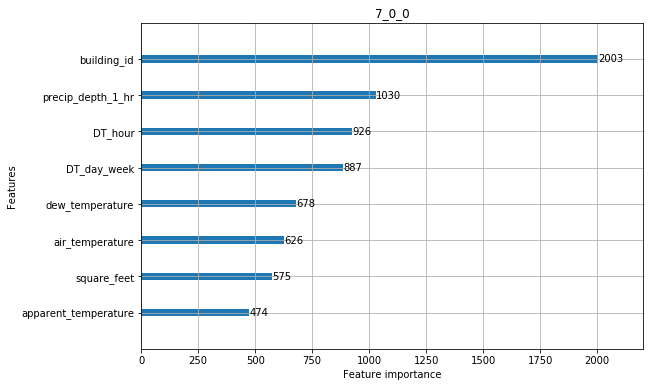

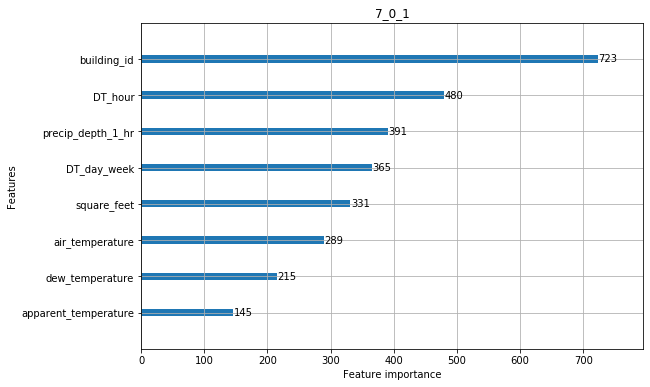

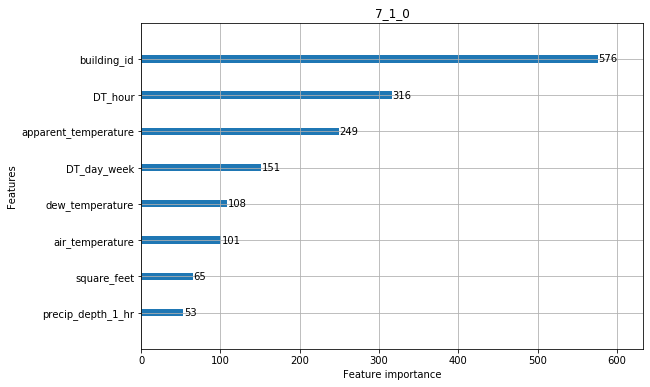

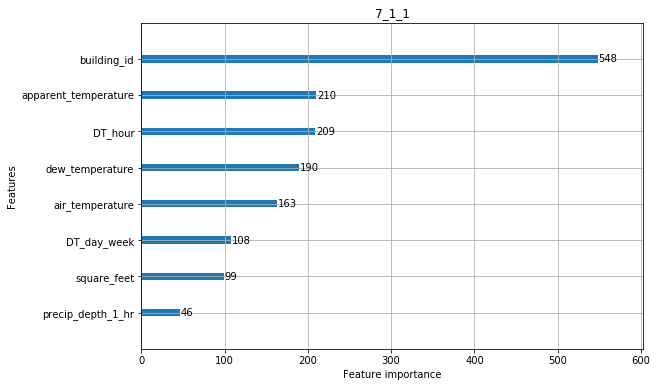

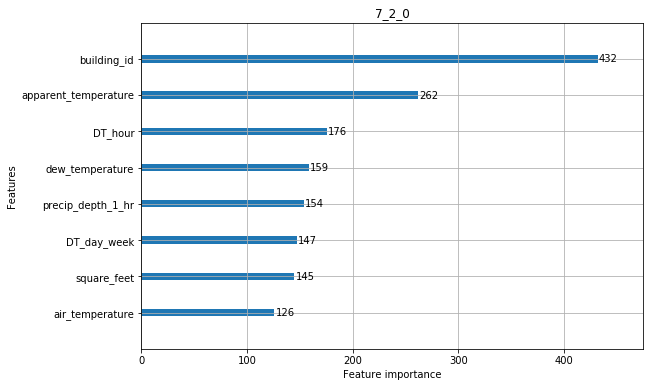

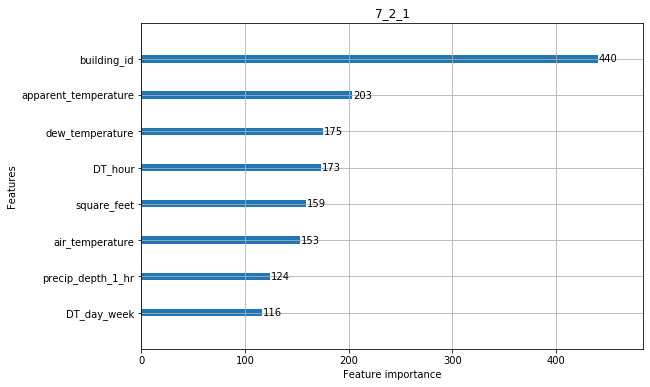

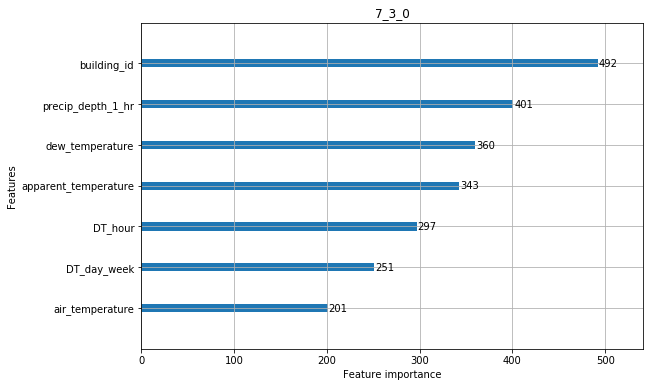

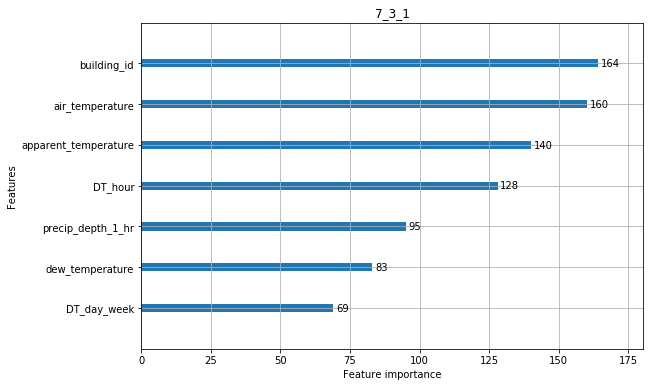

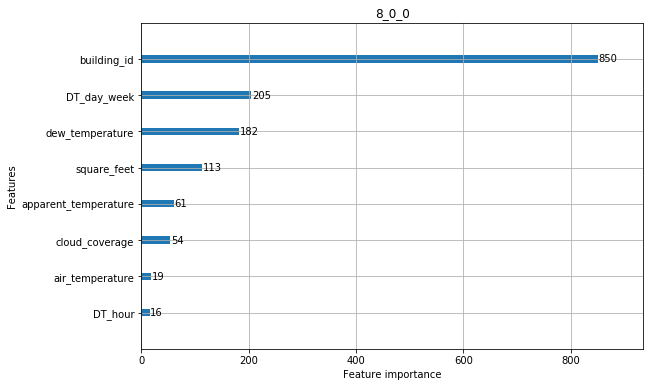

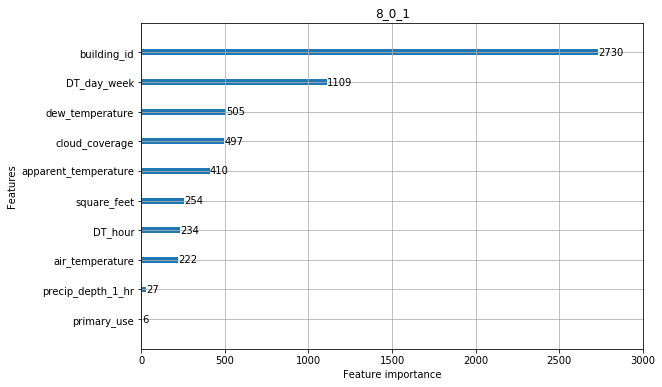

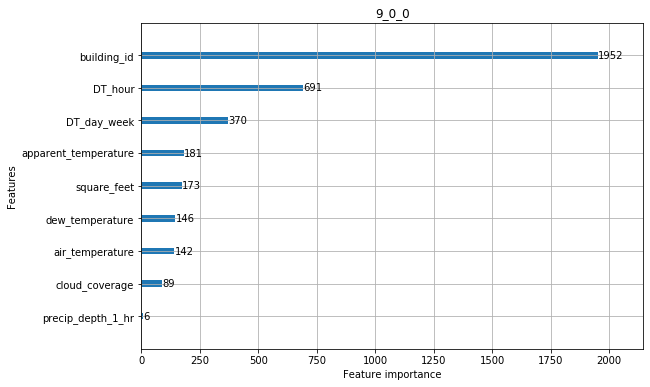

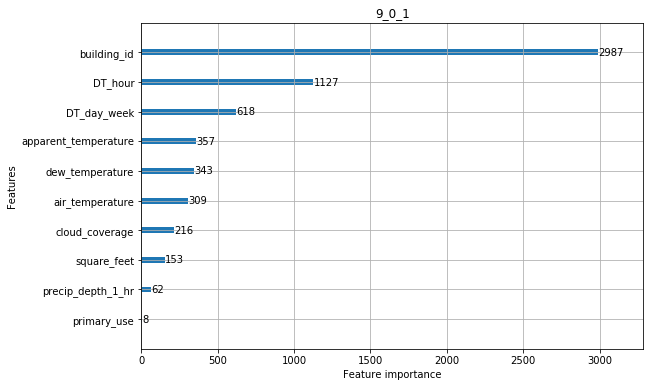

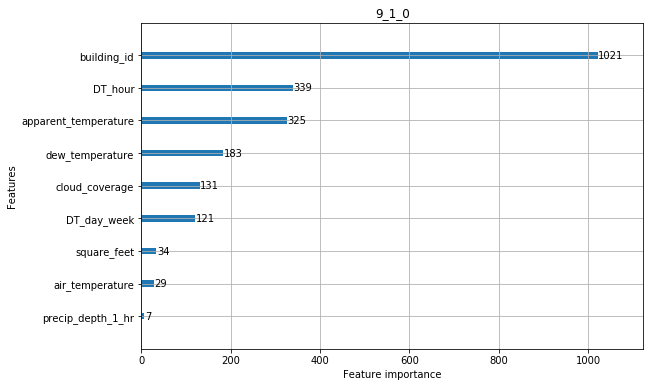

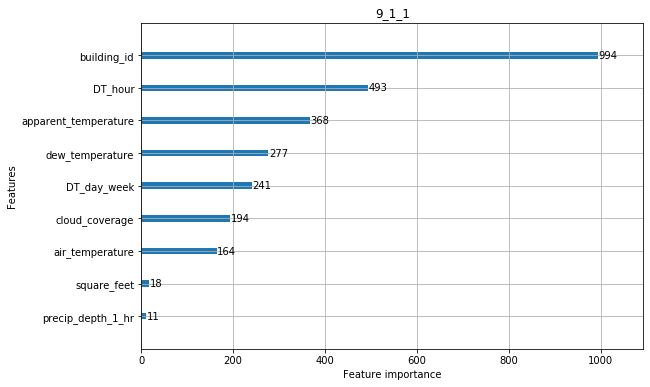

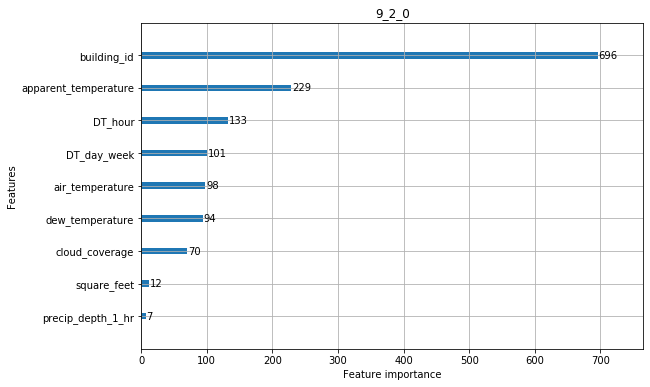

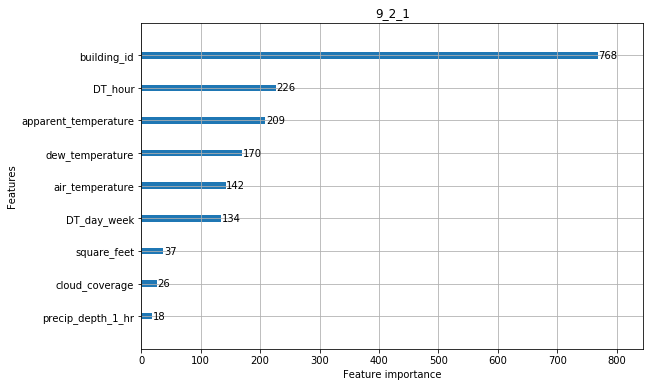

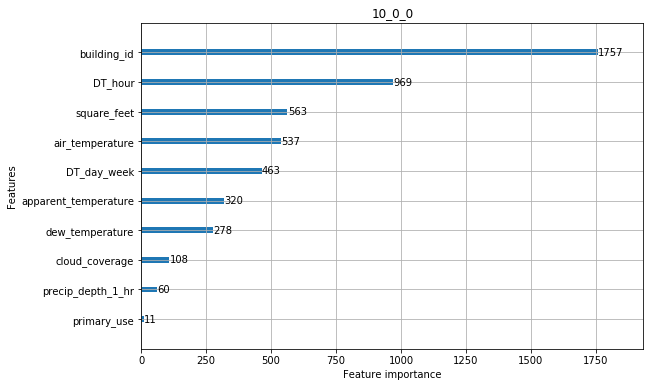

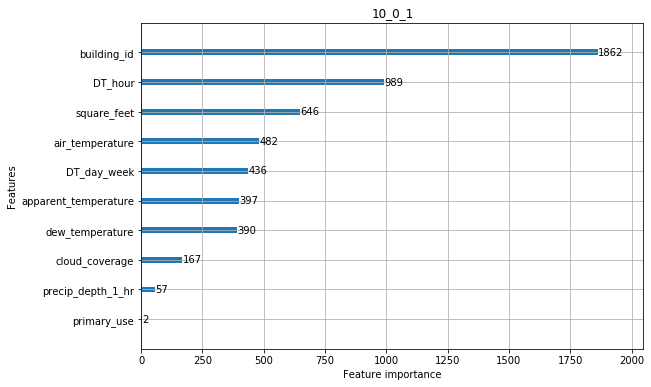

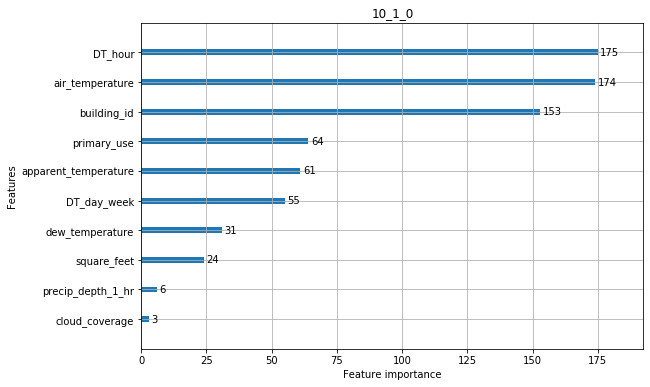

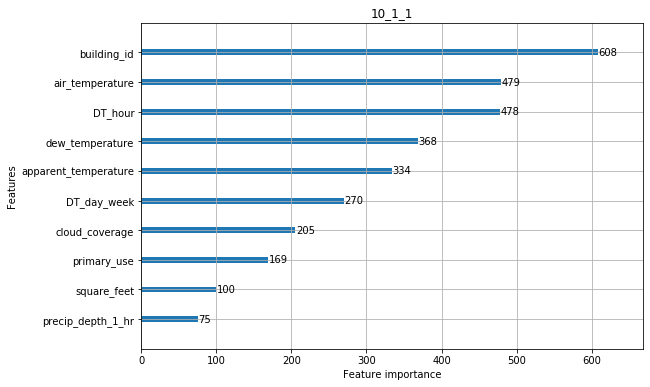

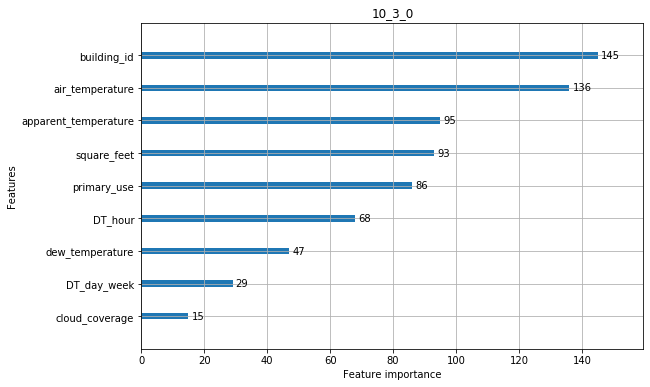

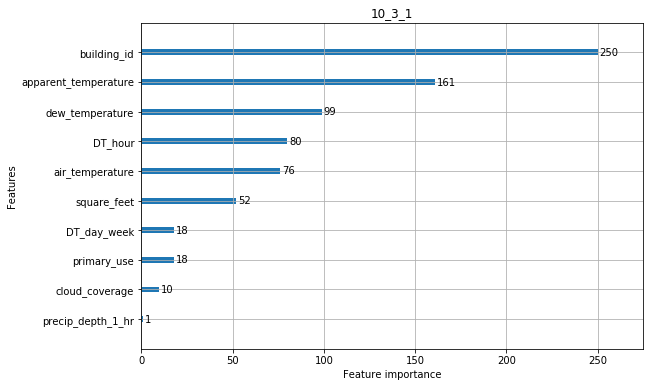

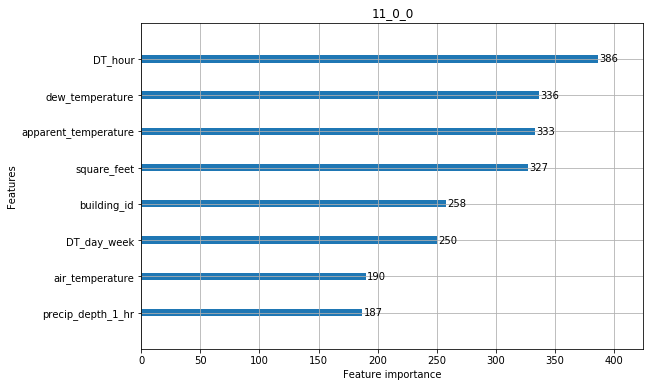

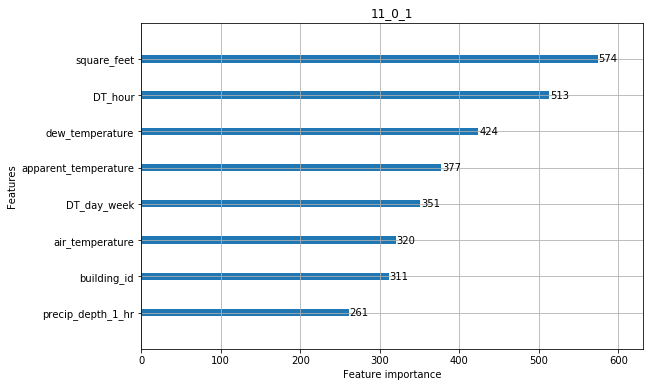

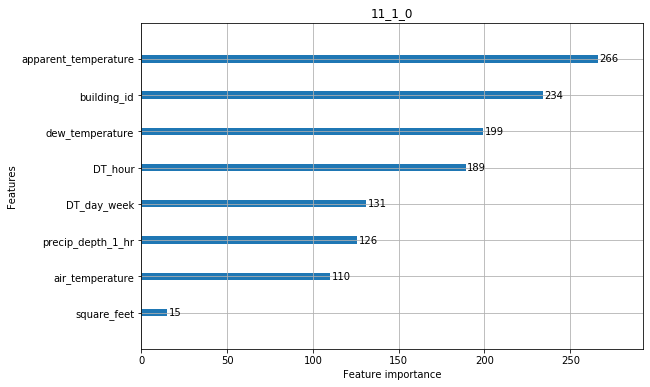

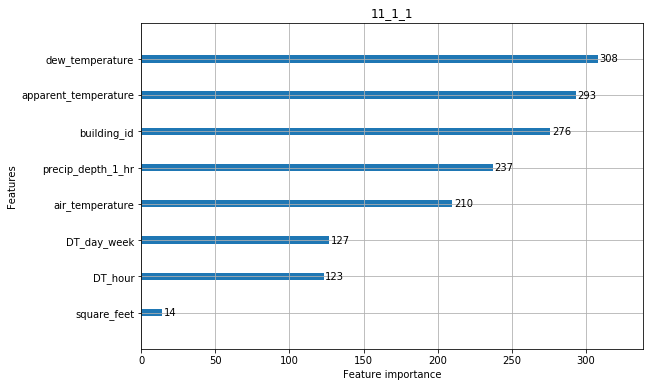

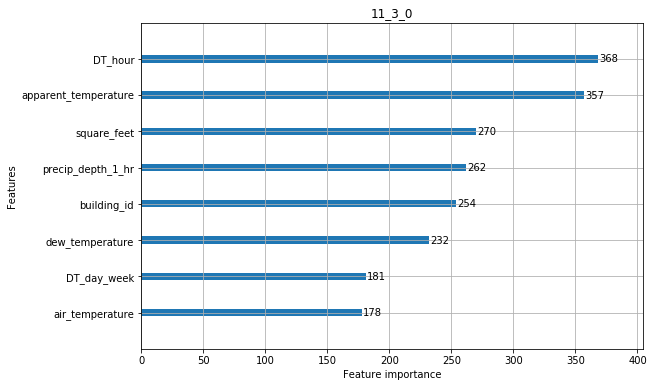

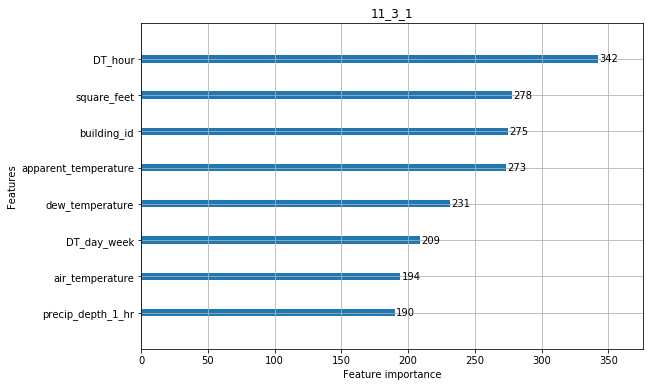

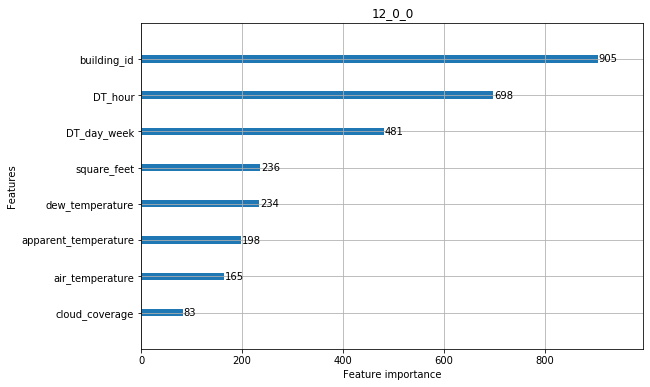

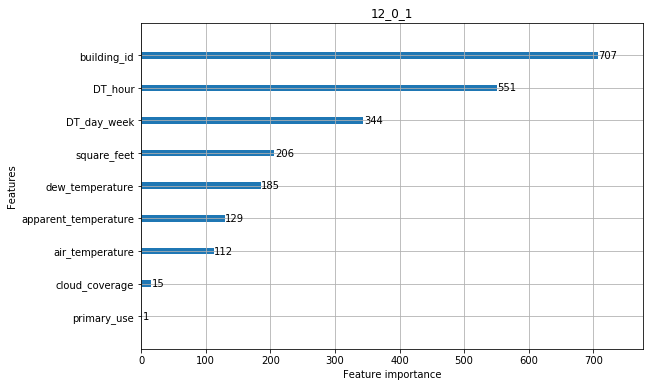

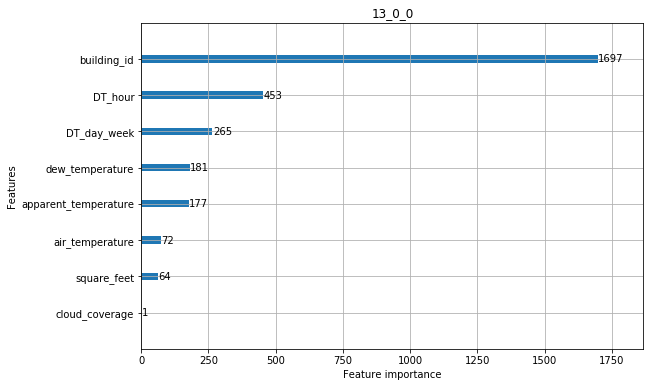

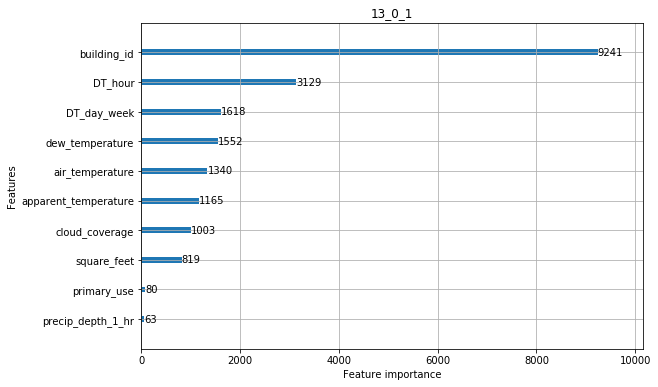

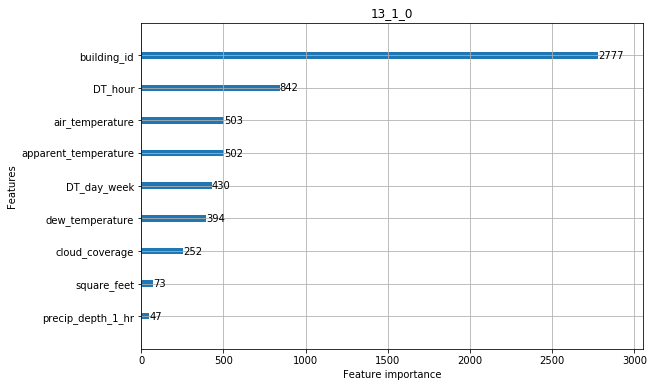

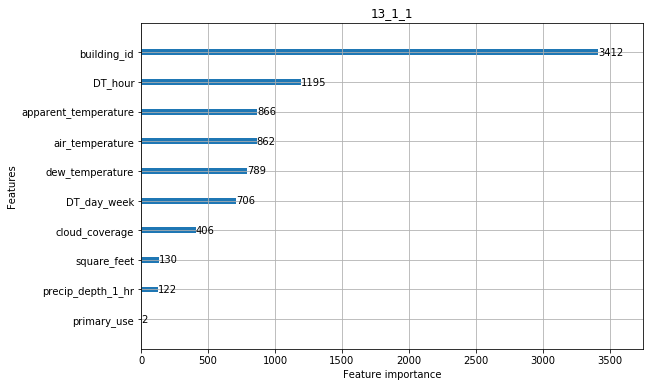

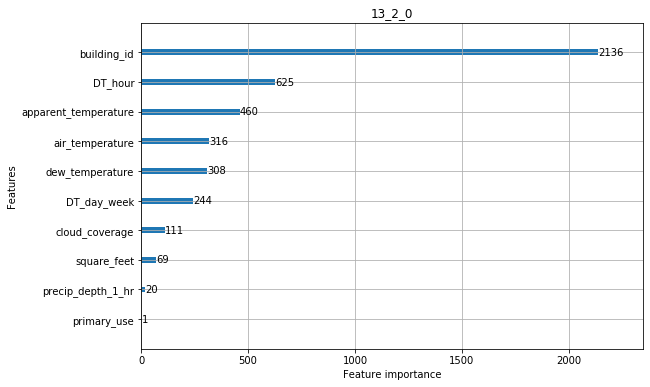

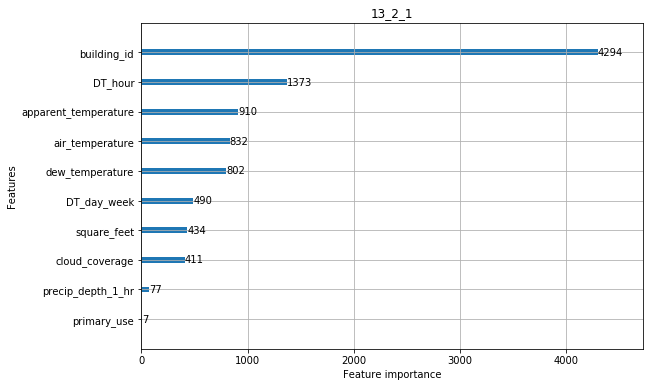

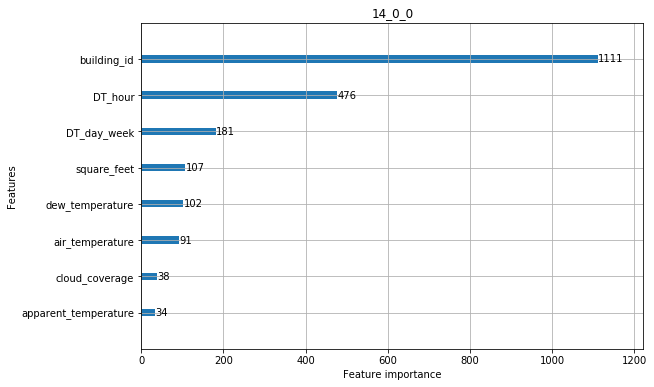

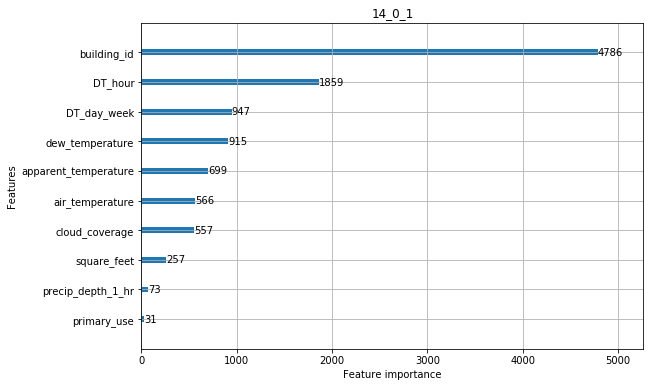

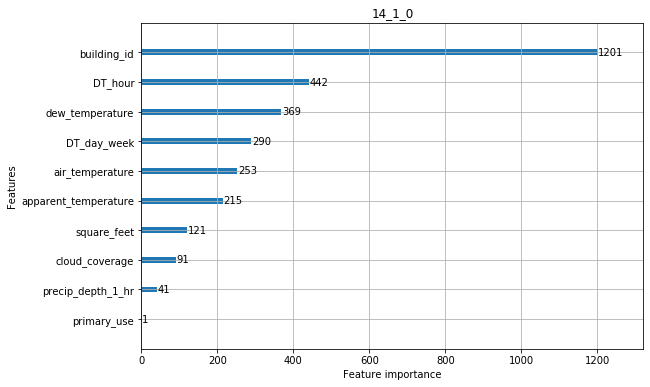

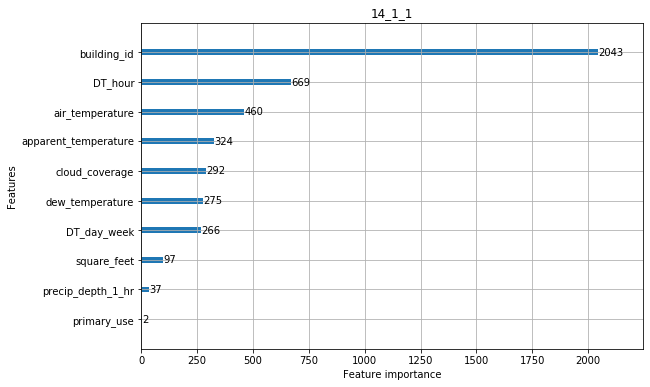

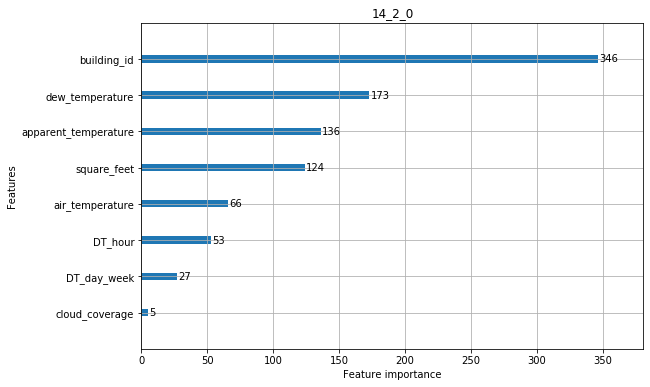

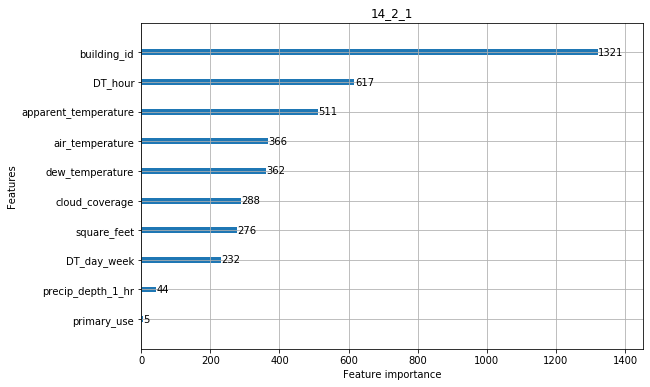

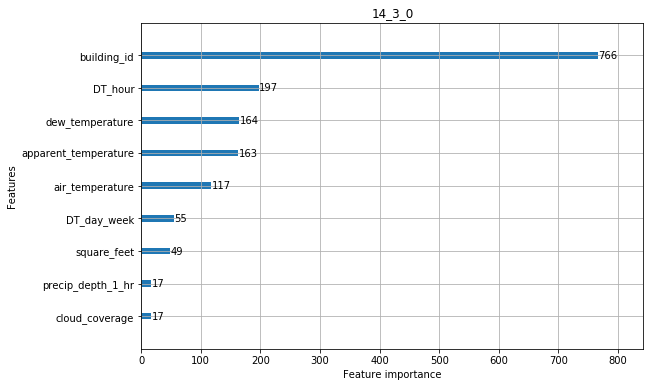

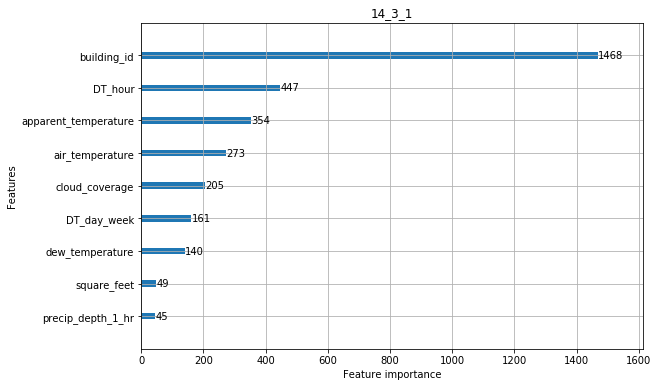

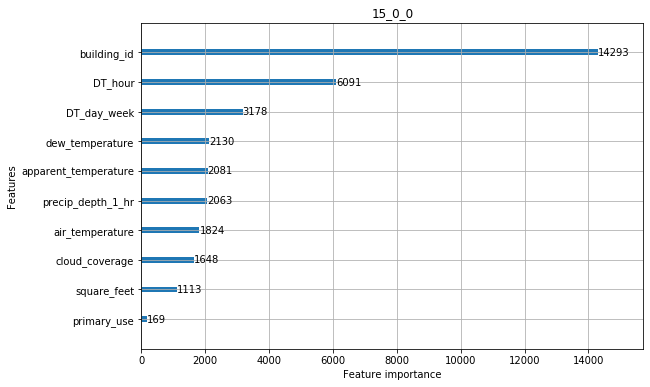

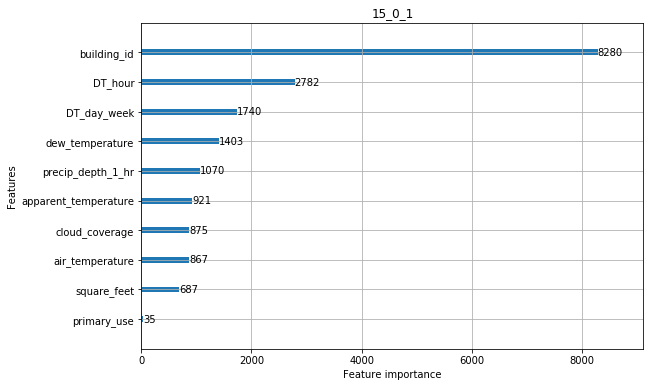

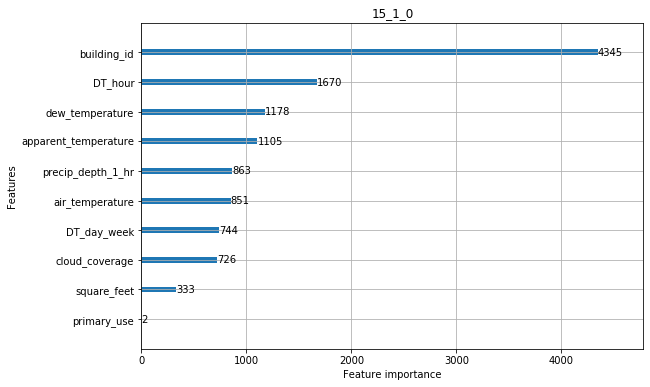

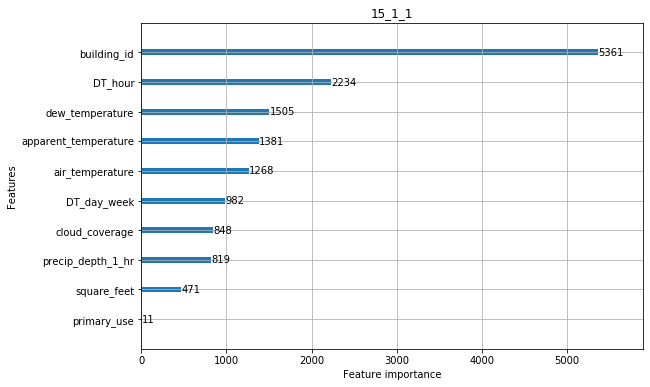

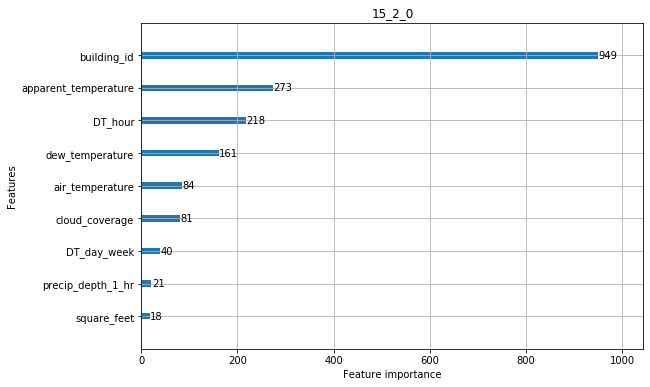

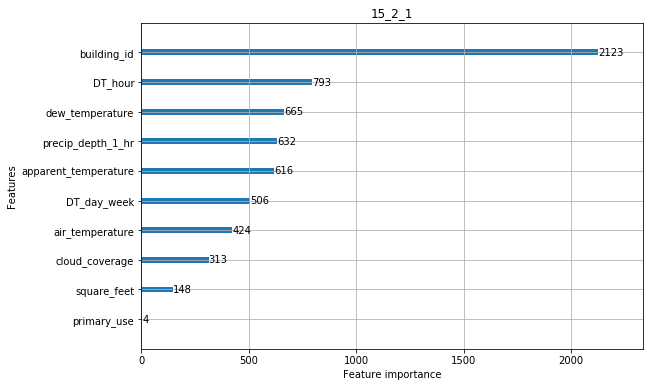

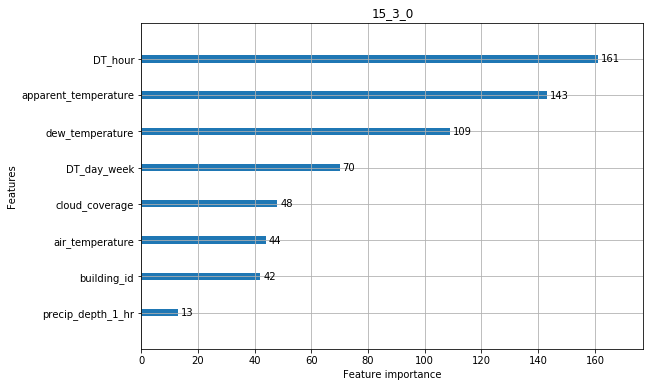

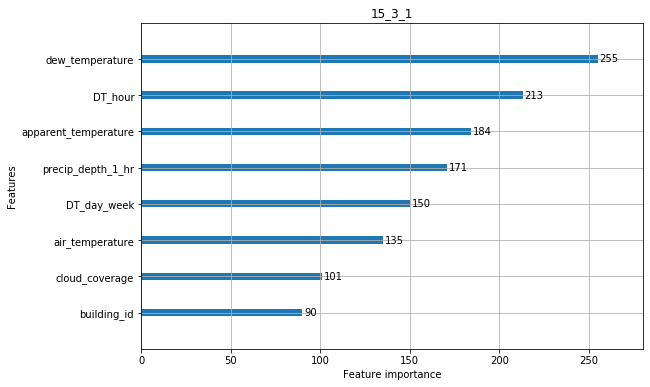

In [10]:
# look at feature importance
for site_id in range(16):
    for meter_id in models[site_id][0].keys():
        for cv_id in range(cv):
            lgb.plot_importance(models[site_id][0][meter_id][cv_id], figsize=(9,6))
            plt.title(str(site_id) + "_" + str(meter_id)+"_"+str(cv_id))
            plt.show()

In [11]:
### make predictions
df_test_sites = []

for site_id in tqdm_notebook(range(16), desc="site_id"):
    
    for meter_id in range(4):
    
        X_test_site = df_test[(df_test.site_id==site_id) & (df_test.meter==meter_id)]
        row_ids_site = X_test_site.row_id

        X_test_site = X_test_site[all_features]
        y_pred_test_site = np.zeros(X_test_site.shape[0])
        
        if(len(X_test_site)==0):
            continue

        for fold in range(cv):
            model_lgb = models[site_id][0][meter_id][fold]
            y_pred_test_site += model_lgb.predict(X_test_site, num_iteration=model_lgb.best_iteration_) / cv
            gc.collect()
        
        df_test_site = pd.DataFrame({"row_id": row_ids_site, "meter_reading": y_pred_test_site})
        df_test_sites.append(df_test_site)
        
        gc.collect()

In [12]:
submit = pd.concat(df_test_sites)
submit.meter_reading = np.clip(np.expm1(submit.meter_reading), 0, a_max=None)
submit.meter_reading = submit.meter_reading.round(4)
print(submit.shape)
submit.head()

(41697600, 2)


,row_id,meter_reading
0,0,186.7230
1156320,66,99.3121
1121280,64,339.5159
1103760,63,315.4487
1138800,65,447.4428


In [13]:
### should be (41697600, 2)
WRITE_TOKEN = True
SUBMIT_TOKEN = False
if((submit.shape == (41697600, 2)) * (WRITE_TOKEN)):
    print("Good, the submission is ready to submit..., submission shape is", submit.shape)
    SUBMISSION_FILE_PATH = "../ensembles/sub_lgb4_grid.csv.gz"
    print("Writing the submission to csv.gz file ...")
    submit.to_csv(SUBMISSION_FILE_PATH, index=False, compression='gzip')
#     if(SUBMIT_TOKEN):
#         print("Submitting the csv.gz file to Kaggle platform ...")
#         !kaggle competitions submit -c ashrae-energy-prediction -f "../submission/sub_lgb.csv.gz" -m "lgb automatic submit ..."
#         print("Submitted successfully! Good luck ...")
else:
    print("There are some things wrong ... The submission is not submitted ...")

Good, the submission is ready to submit..., submission shape is (41697600, 2)
Writing the submission to csv.gz file ...
